# <font color="maroon">Chapter 8: ROMANCE Analysis of Backbone Motion</font>

<a href="https://githubtocolab.com/alsinmr/pyDR_tutorial/blob/main/ColabNotebooks/Ch8_ROMANCE_backbone.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

[ROMANCE](https://doi.org/10.1016/j.jmro.2022.100045) (**R**e**o**rientational Dynamics in **M**D **A**nalyzed for **N**MR **C**orrelation Function Dis-**e**ntanglement) is a method of separating the total correlation function in MD simulations into several components, via the definition of internal reference frames. The idea is, we define some reference frame, and then determine correlation functions describing motion in the frame and motion of the frame. For motion in the frame, we simply align the frame the same way for all time points in the MD trajectory, and calculate the resulting correlation function for the NMR interaction tensor in the frame. Note that we account for reshaping of the interaction tensor due motions within any inner frames, so this may be a relatively complex correlation function (although this does not affect setup for the user, aside from increasing computational time). Then, we additionally calculate a correlation function for the motion of the frame, which also accounts for reshaping of the NMR interaction tensor due to any motion within the frame.

Practically, what the user needs to do is generate a *frame object* which allows definition of the tensor frame (usually just a bond, which may already be defined by the selection object), and allows definition of the additional internal reference frames. Then, the .frames2data() function will create data objects between each pair of frames, plus the total correlation function (no frames) and the product of the individual correlation functions. Note that for $N$ internal reference frames, we have $N+2$ frames in total (including the tensor frame, i.e. PAS, and lab frames), and thus have $N+1$ separated motions.

## Setup and data downloads
Since we've learned now how pyDR is organized and allows us to manage larger data sets, we'll now use the full project functionality.

In [0]:
# SETUP pyDR
import os
os.chdir('../..')

In [2]:
#Imports
import numpy as np
import pyDR

In [4]:
# Project Creation and File loading
proj=pyDR.Project()

sel=pyDR.MolSelect(topo='pyDR/examples/HETs15N/backboneB.pdb',
                   traj_files='pyDR/examples/HETs15N/backboneB.xtc',
                   project=proj)  #Selection object

# Specify the bond select to analyze for MD
sel.select_bond('N')

sel.traj.step=50  #Take every tenth point for MD calculation (set to 1 for more accurate calculation)
pyDR.Defaults['ProgressBar']=False #Turns of the Progress bar (screws up webpage compilation)

## Run the frame analysis

### Setup the frame analysis
Frame analysis always uses the first frame to be the principal axis frame (i.e. tensor_frame), and the last frame to be the lab frame. In this example, we insert two additional frames: a peptide_plane frame, which separates H–N librational motion in and out of the peptide plane from motion of the peptide plane, and a superimpose frame, which in this case we align to 8 $\beta$-sheets, allowing us to separate out peptide plane motion in the $\beta$-sheet to motion of the $\beta$-sheets themselves.

In [5]:
from numpy import nan
bsheets=[(226,228),(230,234),(236,240),(242,245),
         (262,264),(266,270),(272,276),(278,281)]

# Define second reference frame (beta sheets)
sel0=[sel.uni.select_atoms(f'resid {bsheet[0]}-{bsheet[1]}') for bsheet in bsheets]

fo=pyDR.Frames.FrameObj(sel)
fo.tensor_frame(sel1=1,sel2=2)  #Define the frame of the interaction (dipole tensor)
fo.new_frame(Type='peptide_plane',resids=sel.label) #Define first reference frame
fo.new_frame(Type='superimpose',sel=sel0) #Define second reference frame

### Import the frames, process

In [6]:
fo.frames2data()  #Process frames, send to data
proj['Frames'].detect.r_auto(6)  #Prepare detectors
proj['Frames'].fit().opt2dist(rhoz_cleanup=True)  #Fit and optimize fit

Using symmetric calculation for 70 correlation functions
Using symmetric calculation for 70 correlation functions
Fitted 5 data objects
Optimized 5 data objects
pyDIFRATE project with 5 data sets

Titles:
o6:FRAMES:Direct:backboneB
o6:FRAMES:Product:backboneB
o6:FRAMES:PAS>peptide_plane:backboneB
o6:FRAMES:peptide_plane>superimpose:backboneB
o6:FRAMES:superimpose>LF:backboneB


### Validate the frame analysis

First, we validate the frame analysis quality by comparing the product of the individual correlation functions to the total correlation function. It can be the case that motion in one frame and of one frame are not statistically independent, or not sufficiently separated in timescale. In this case, the product of correlation functions and the total correlation function will be significantly different, resulting in disagreement in the detector analysis below. In this case, caution must be taken in interpreting the results of the frame analysis.

In the analysis here, we find the total and product correlation functions to be in good agreement. 

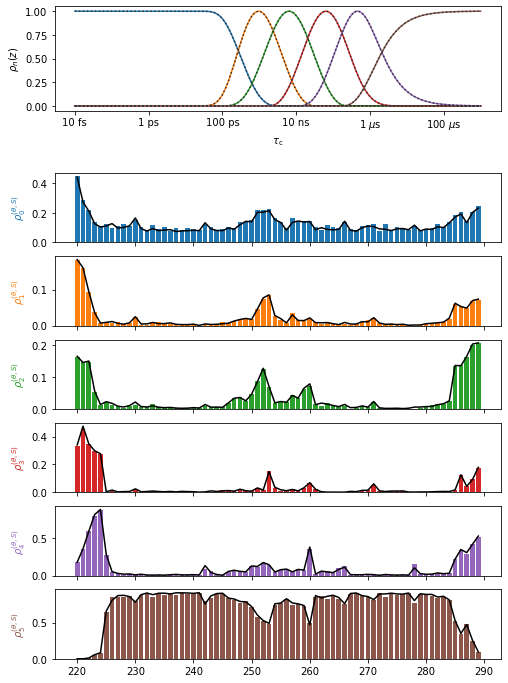

In [7]:
proj.close_fig('all')
proj['opt_fit']['Frames']['Direct'].plot(style='bar')
proj['opt_fit']['Frames']['Product'].plot().fig.set_size_inches([8,12])

### Plot the individual frames

Plot the results for the Principal Axis System to the peptide plane (H–N librational motion)

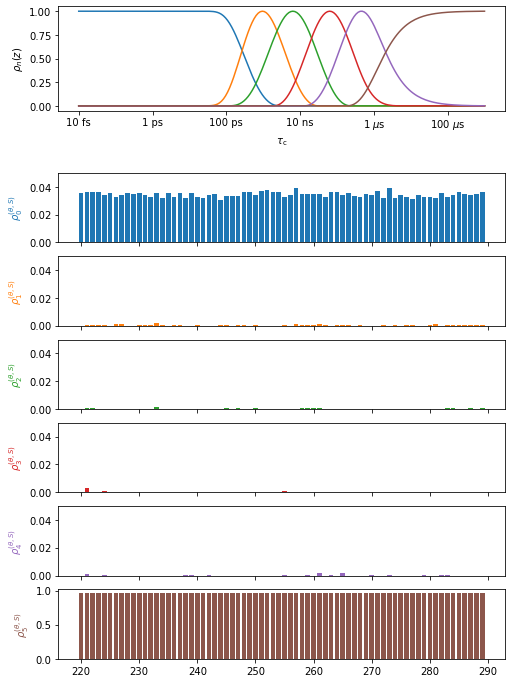

In [8]:
proj.close_fig('all')
proj['opt_fit']['PAS>peptide_plane'].plot(style='bar').fig.set_size_inches([8,12])
for a in proj.plot_obj.ax[:-1]:a.set_ylim([0,.05])

Plot the results for peptide plane to $\beta$-sheet superimposition (peptide plane dynamics)

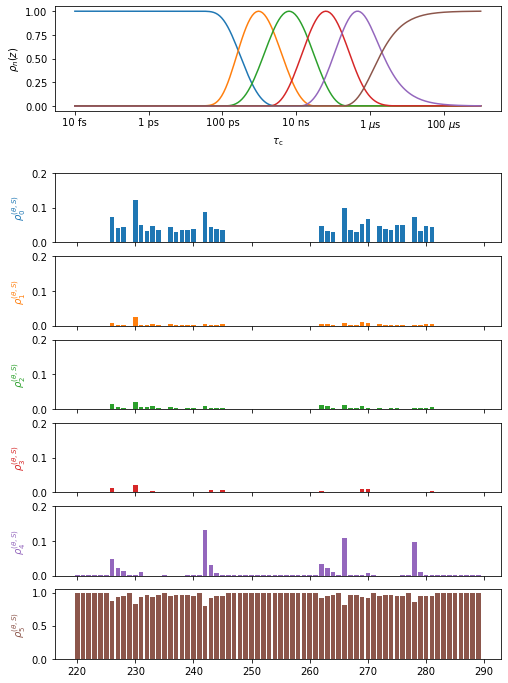

In [9]:
proj.close_fig('all')
proj['opt_fit']['peptide_plane>superimpose'].plot(style='bar').fig.set_size_inches([8,12])
for a in proj.plot_obj.ax[:-1]:a.set_ylim([0,.2])

Plot the results for $\beta$-sheet superimposition to lab frame ($\beta$-sheet dynamics). Note we only show residues contained in $\beta$-sheets. For residues not in $\beta$-sheets, there is no second reference frame defined. However, these are by default still analyzed. In the previous plot, they simply exhibit no motion, since the frame is missing. In the next plot, they are actively excluded, since the missing frame makes the results significantly different. Leave 'index' out of the plot command to view these residues.

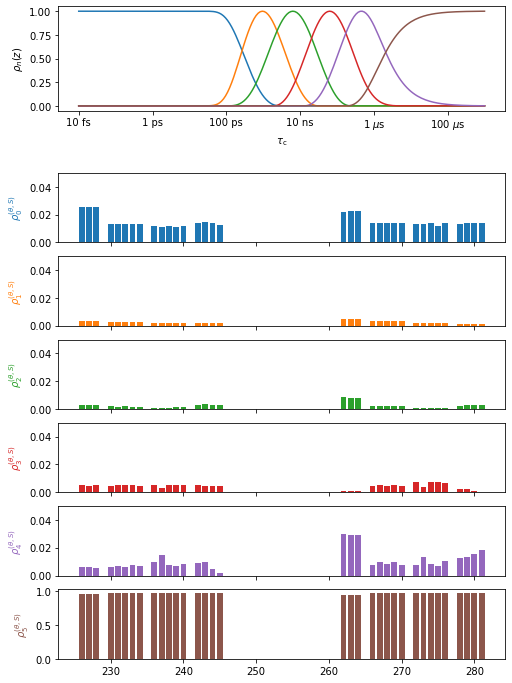

In [10]:
proj.close_fig('all')
# Just show the beta sheets via index
resids=proj['opt_fit']['Direct'].label
index=np.zeros(len(resids),dtype=bool)
for bsheet in bsheets:
    index[np.argwhere(bsheet[0]==resids)[0,0]:np.argwhere(bsheet[1]==resids)[0,0]+1]=1
proj['opt_fit']['superimpose>LF'].plot(style='bar',index=index).fig.set_size_inches([8,12])
for a in proj.plot_obj.ax[:-1]:a.set_ylim([0,.05])